# Utility functions and tests (to be integrated w/ source code)


In [1]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import y0
import nocap
from IPython.display import Latex
import json
import os
import pandas as pd
import re
import fileinput
import sys
import shutil

# you may need to fix  error w/ causalgraphicalmodels and new python versions
# change "from collections import Iterable" to "from collections.abc import Iterable" in cgm.py

# Path to the cgm.py file (update this to the correct path on your system)
# cgm_file_path = "/path/to/causalgraphicalmodels/cgm.py"

# shutil.copyfile(cgm_file_path, cgm_file_path + ".bak")  # Create a backup of the original file

# Replace the import statement
# with fileinput.FileInput(cgm_file_path, inplace=True) as file:
#     for line in file:
#         print(line.replace("from collections import Iterable", "from collections.abc import Iterable"), end='')


from causalgraphicalmodels import CausalGraphicalModel

### parse a biocyc network regulation text file and convert it into a networkx directed graph

In [2]:


def parse_regulation_file(file_path):
    "Parses a biocyc network regulation text file and converts it into a directed graph."
    # Regulation text file should have the following format: 
    # '#' for comments.
    # All regulators have a "*" after their name.
    # Top level (master) regulators are not indented. 
    # descendants of the regulator are indented and spaced on the subsequent line. 
    # The regulatees are prefixed with a '+', '-', or '+/-' for polarity.


    # Create a directed graph to represent the network
    G = nx.DiGraph()

    # Open and read the file line by line
    with open(file_path, 'r') as file:
        current_regulator = None  # Initialize the current regulator variable
        for line in file:
            # Ignore lines starting with '#' or that are empty
            if line.startswith('#') or not line.strip():
                continue

            # Remove trailing whitespace from the line
            line = line.rstrip()

            # Check if a line does not start with an indent and also ends with an asterisk
            if not line.startswith('  ') and line.endswith('*'):
                # Remove the asterisk and set that as the current_regulator
                current_regulator = line[:-1].strip()
                # Make first letter uppercase
                current_regulator = current_regulator[0].upper() + current_regulator[1:]
                # If the current regulator is not already in the graph, add it
                if current_regulator not in G:
                    G.add_node(current_regulator)
            elif current_regulator and line.startswith('  '):
                # Process the regulatees
                regulatees = line.strip().split()
                for regulatee in regulatees:
                    # Determine the polarity and adjust slicing accordingly
                    if regulatee.startswith('+/-'):
                        polarity = '+/-'
                        gene = regulatee[3:]
                    elif regulatee.startswith('+') or regulatee.startswith('-'):
                        polarity = regulatee[0]
                        gene = regulatee[1:]
                    else:
                        polarity = None
                        gene = regulatee

                    # Remove the trailing asterisk if present
                    gene = gene.rstrip('*')
                    # Make first letter uppercase
                    gene = gene[0].upper() + gene[1:]

                    # If the regulatee is not in the graph, add it
                    if gene not in G:
                        G.add_node(gene)
                    # Add an edge between the current_regulator and the regulatee with the polarity as an attribute
                    G.add_edge(current_regulator, gene, polarity=polarity)
    return G



def test_parse_regulation_file_simple():
    "Checks that the expected and actual graphs are identical after parsing."
    # Path to the file with the regulation data
    file_path = 'simple_regulation_network.txt'
    
    # Parse the file using the function
    G = parse_regulation_file(file_path)
    
    # Define the expected graph structure
    expected_G = nx.DiGraph()
    expected_G.add_edges_from([
        ('GeneA', 'GeneA', {'polarity': '+'}),
        ('GeneA', 'GeneB', {'polarity': '+'}),
        ('GeneA', 'GeneC', {'polarity': '+'}),
        ('GeneB', 'GeneB', {'polarity': '-'}),
        ('GeneB', 'GeneC', {'polarity': '-'}),
        ('GeneC', 'GeneD', {'polarity': '+/-'}),
    ])
    
    # Assert that the two graphs are equal
    assert nx.is_isomorphic(G, expected_G, edge_match=nx.algorithms.isomorphism.categorical_edge_match('polarity', None)), "The graphs are not isomorphic or the edge polarities do not match."
    

# Call the test function
test_parse_regulation_file_simple()

### convert cyclic directed graph into acyclic directed graph

In [3]:
def convert_to_acyclic_graph(graph):
    """Converts a (cyclic) directed graph into an acyclic directed graph by removing edges and disconnected nodes."""
    G = graph.copy()

    # Remove self-loops
    self_loops = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loops)

    # Remove nodes that became disconnected after removing self-loops
    for u, v in self_loops:
        if G.degree(u) == 0:
            G.remove_node(u)

    # If the graph is still cyclic, find and break the cycles
    if not nx.is_directed_acyclic_graph(G):
        cycles = list(nx.simple_cycles(G))
        for cycle in cycles:
            # Remove one edge from the cycle
            G.remove_edge(cycle[-1], cycle[0])
            # Remove nodes that became disconnected after removing the edge
            if G.degree(cycle[-1]) == 0:
                G.remove_node(cycle[-1])
            if G.degree(cycle[0]) == 0:
                G.remove_node(cycle[0])

    return G


def test_convert_to_acyclic_graph():
    """Tests if a graph is correctly converted into an acyclic graph."""
    # Create a directed graph representing a simple gene regulatory network
    cyclic_graph = nx.DiGraph()
    cyclic_graph.add_edges_from([
        ('Gene1', 'Gene2'),  # Gene1 activates Gene2
        ('Gene2', 'Gene3'),  # Gene2 activates Gene3
        ('Gene3', 'Gene1'),  # Gene3 activates Gene1, forming a cycle
        ('Gene3', 'Gene3'),  # Gene3 regulates itself, a self-loop
        ('Gene4', 'Gene2'),  # Gene4 activates Gene2, not part of a cycle
    ])

    # Convert the cyclic graph to an acyclic one
    acyclic_graph = convert_to_acyclic_graph(cyclic_graph)

    # Test if the resulting graph is acyclic
    assert nx.is_directed_acyclic_graph(acyclic_graph), "The graph is not acyclic."

    # Test if the self-loop has been removed
    assert not acyclic_graph.has_edge('Gene3', 'Gene3'), "The self-loop has not been removed."

    # Test if the larger cycle has been broken by checking for cycles
    assert len(list(nx.simple_cycles(acyclic_graph))) == 0, "The cycle has not been broken."

    # Test if non-cycle edges are preserved
    assert acyclic_graph.has_edge('Gene4', 'Gene2'), "The edge not part of a cycle was incorrectly removed."

test_convert_to_acyclic_graph()

In [4]:
def convert_to_acyclic_graph_dfs(graph):
    """Converts a (cyclic) directed graph into an acyclic directed graph using depth-first search to remove back edges."""
    G = graph.copy()
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    dfs_edges = list(nx.dfs_edges(G))
    back_edges = set(G.edges()) - set(dfs_edges)
    G.remove_edges_from(back_edges)
    
    # Keep only the largest strongly connected component
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    for node in set(G.nodes()) - largest_scc:
        G.remove_node(node)
    
    return G

def test_convert_to_acyclic_graph_dfs():
    """Tests if a graph is correctly converted into an acyclic graph using depth-first search."""
    # Create a directed graph representing a simple gene regulatory network
    cyclic_graph = nx.DiGraph()
    cyclic_graph.add_edges_from([
        ('Gene1', 'Gene2'),
        ('Gene2', 'Gene3'),
        ('Gene3', 'Gene1'),  # Cycle
        ('Gene3', 'Gene3'),  # Self-loop
        ('Gene4', 'Gene2'),  # Not part of a cycle
    ])

    # Convert the cyclic graph to an acyclic one using depth-first search
    acyclic_graph_dfs = convert_to_acyclic_graph_dfs(cyclic_graph)

    # Test if the resulting graph is acyclic
    assert nx.is_directed_acyclic_graph(acyclic_graph_dfs), "The graph is not acyclic."

    # Test if the resulting graph has no self-loops
    assert not list(nx.selfloop_edges(acyclic_graph_dfs)), "The graph has self-loops."

    # Test if the resulting graph is strongly connected
    assert nx.is_strongly_connected(acyclic_graph_dfs), "The graph is not strongly connected."

     # Test case 2: Graph with multiple separate cycles
    cyclic_graph2 = nx.DiGraph()
    cyclic_graph2.add_edges_from([
        ('Gene1', 'Gene2'),
        ('Gene2', 'Gene1'),  # Cycle 1
        ('Gene3', 'Gene4'),
        ('Gene4', 'Gene3'),  # Cycle 2
    ])
    acyclic_graph2 = convert_to_acyclic_graph(cyclic_graph2)
    assert nx.is_directed_acyclic_graph(acyclic_graph2), "The graph is not acyclic."

    # Test case 3: Graph with nested cycles
    cyclic_graph3 = nx.DiGraph()
    cyclic_graph3.add_edges_from([
        ('Gene1', 'Gene2'),
        ('Gene2', 'Gene3'),
        ('Gene3', 'Gene1'),  # Outer cycle
        ('Gene2', 'Gene4'),
        ('Gene4', 'Gene2'),  # Inner cycle
    ])
    acyclic_graph3 = convert_to_acyclic_graph(cyclic_graph3)
    assert nx.is_directed_acyclic_graph(acyclic_graph3), "The graph is not acyclic."

    # Test case 4: Graph with a single node
    cyclic_graph4 = nx.DiGraph()
    cyclic_graph4.add_node('Gene1')
    acyclic_graph4 = convert_to_acyclic_graph(cyclic_graph4)
    assert nx.is_directed_acyclic_graph(acyclic_graph4), "The graph is not acyclic."

    print("All assertions passed for convert_to_acyclic_graph.")

# Run the test function
test_convert_to_acyclic_graph()


test_convert_to_acyclic_graph_dfs()


All assertions passed for convert_to_acyclic_graph.


In [5]:
# def convert_to_acyclic_graph_toposort(graph):
#     """Converts a (cyclic) directed graph into an acyclic directed graph using topological sorting to remove cycles."""
#     G = graph.copy()

#     # Remove self-loops
#     G.remove_edges_from(nx.selfloop_edges(G))

#     # Perform a topological sort on the nodes in the graph
#     topo_order = list(nx.topological_sort(nx.DiGraph(G.edges())))

#     # Reconstruct the graph using the topological ordering
#     acyclic_G = nx.DiGraph()
#     acyclic_G.add_nodes_from(topo_order)
#     for u, v in G.edges():
#         if topo_order.index(u) < topo_order.index(v):
#             acyclic_G.add_edge(u, v)

#     return acyclic_G


# def test_convert_to_acyclic_graph_toposort():
#     """Tests if a graph is correctly converted into an acyclic graph using topological sorting."""
#     # Create a directed graph representing a simple gene regulatory network
#     cyclic_graph = nx.DiGraph()
#     cyclic_graph.add_edges_from([
#         ('Gene1', 'Gene2'),
#         ('Gene2', 'Gene3'),
#         ('Gene3', 'Gene1'),  # Cycle
#         ('Gene3', 'Gene3'),  # Self-loop
#         ('Gene4', 'Gene2'),  # Not part of a cycle
#     ])

#     # Convert the cyclic graph to an acyclic one using topological sorting
#     acyclic_graph_toposort = convert_to_acyclic_graph_toposort(cyclic_graph)

#     # Test if the resulting graph is acyclic
#     assert nx.is_directed_acyclic_graph(acyclic_graph_toposort), "The graph is not acyclic."

#     # Test if the resulting graph has no self-loops
#     assert not list(nx.selfloop_edges(acyclic_graph_toposort)), "The graph has self-loops."

#     print("All assertions passed for convert_to_acyclic_graph_toposort.")

# # Run the test function
# test_convert_to_acyclic_graph_toposort()


### generate a subnetwork from a target node, descendants, and all valid backdoor adjustment sets

In [6]:
def generate_subnetwork_with_backdoor_adjustment(graph, target_gene):
    # Create a new directed graph for the subnetwork
    subnetwork = nx.DiGraph()

    # Step 1: Identify the target gene and its descendants
    descendants = nx.descendants(graph, target_gene)
    # Include the target gene itself in the set
    descendants.add(target_gene)
    print(f"Descendants of {target_gene}: {descendants}")  # Debug print

    # Step 2: Determine the backdoor adjustment set
    # Convert the networkx graph to a CausalGraphicalModel
    cgm = CausalGraphicalModel(
        nodes=list(graph.nodes),
        edges=[(u, v) for u, v in graph.edges]
    )
    # Get the backdoor adjustment set for the target gene
    backdoor_adjustment_set = set()
    for node in graph.nodes:
        if node != target_gene:
            for adjustment_set in cgm.get_all_backdoor_adjustment_sets(node, target_gene):
                backdoor_adjustment_set.update(adjustment_set)
    print(f"Backdoor adjustment set for {target_gene}: {backdoor_adjustment_set}")  # Debug print

    # Step 3: Construct the subnetwork
    # Add nodes for the target gene, its descendants, and the backdoor adjustment set
    subnetwork.add_nodes_from(descendants.union(backdoor_adjustment_set))
    print(f"Nodes in the subnetwork: {set(subnetwork.nodes())}")  # Debug print

    # Add edges between the nodes in the subnetwork that exist in the original graph
    for u, v in graph.edges():
        if u in subnetwork.nodes() and v in subnetwork.nodes():
            subnetwork.add_edge(u, v, polarity=graph[u][v]['polarity'])

    print(f"Edges in the subnetwork: {set(subnetwork.edges())}")  # Debug print

    return subnetwork


def test_generate_subnetwork_with_backdoor_adjustment():
    # Test case 1: Simple graph with 1 target gene and 2 descendants, no backdoor paths
    graph1 = nx.DiGraph()
    graph1.add_edge('GeneM', 'GeneT1', polarity='+')
    graph1.add_edge('GeneM', 'GeneT2', polarity='-')
    subnetwork1 = generate_subnetwork_with_backdoor_adjustment(graph1, 'GeneM')
    assert set(subnetwork1.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork1.edges()) == {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2')}

    # Test case 2: More complex graph with 1 target gene, 2 descendants, and 1 backdoor path
    graph2 = nx.DiGraph()
    graph2.add_edge('GeneM', 'GeneT1', polarity='+')
    graph2.add_edge('GeneM', 'GeneT2', polarity='-')
    graph2.add_edge('GeneT1', 'GeneT2', polarity='+')  # Backdoor path
    subnetwork2 = generate_subnetwork_with_backdoor_adjustment(graph2, 'GeneM')
    assert set(subnetwork2.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork2.edges()) == {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2'), ('GeneT1', 'GeneT2')}

    # Test case 3: Graph with 1 target gene, 3 descendants, and multiple backdoor paths
    graph3 = nx.DiGraph()
    graph3.add_edge('GeneM', 'GeneT1', polarity='+')
    graph3.add_edge('GeneM', 'GeneT2', polarity='-')
    graph3.add_edge('GeneT1', 'GeneT3', polarity='+')  # Backdoor path
    graph3.add_edge('GeneT2', 'GeneT3', polarity='+')  # Another backdoor path
    subnetwork3 = generate_subnetwork_with_backdoor_adjustment(graph3, 'GeneM')
    assert set(subnetwork3.nodes()) == {'GeneM', 'GeneT1', 'GeneT2', 'GeneT3'}
    assert set(subnetwork3.edges()) == {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2'), ('GeneT1', 'GeneT3'), ('GeneT2', 'GeneT3')}

    # Test case 4: Single node graph
    graph4 = nx.DiGraph()
    graph4.add_node('GeneM')
    subnetwork4 = generate_subnetwork_with_backdoor_adjustment(graph4, 'GeneM')
    assert set(subnetwork4.nodes()) == {'GeneM'}
    assert set(subnetwork4.edges()) == set()

    # Test case 5: Linear graph
    graph5 = nx.DiGraph()
    graph5.add_edge('GeneM', 'GeneT1', polarity='+')
    graph5.add_edge('GeneT1', 'GeneT2', polarity='+')
    subnetwork5 = generate_subnetwork_with_backdoor_adjustment(graph5, 'GeneM')
    assert set(subnetwork5.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork5.edges()) == {('GeneM', 'GeneT1'), ('GeneT1', 'GeneT2')}

    # Test case 6: Diverging graph
    graph6 = nx.DiGraph()
    graph6.add_edge('GeneM', 'GeneT1', polarity='+')
    graph6.add_edge('GeneM', 'GeneT2', polarity='+')
    subnetwork6 = generate_subnetwork_with_backdoor_adjustment(graph6, 'GeneM')
    assert set(subnetwork6.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork6.edges()) == {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2')}

    # Test case 7: Converging graph
    graph7 = nx.DiGraph()
    graph7.add_edge('GeneT1', 'GeneM', polarity='+')
    graph7.add_edge('GeneT2', 'GeneM', polarity='+')
    subnetwork7 = generate_subnetwork_with_backdoor_adjustment(graph7, 'GeneM')
    assert set(subnetwork7.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork7.edges()) == {('GeneT1', 'GeneM'), ('GeneT2', 'GeneM')}

    print("All assertions passed for generate_subnetwork_with_backdoor_adjustment.")


# Run the test function
test_generate_subnetwork_with_backdoor_adjustment()

Descendants of GeneM: {'GeneT1', 'GeneT2', 'GeneM'}
Backdoor adjustment set for GeneM: {'GeneT1', 'GeneT2'}
Nodes in the subnetwork: {'GeneT1', 'GeneT2', 'GeneM'}
Edges in the subnetwork: {('GeneM', 'GeneT2'), ('GeneM', 'GeneT1')}
Descendants of GeneM: {'GeneT1', 'GeneT2', 'GeneM'}
Backdoor adjustment set for GeneM: {'GeneT1'}
Nodes in the subnetwork: {'GeneT1', 'GeneT2', 'GeneM'}
Edges in the subnetwork: {('GeneM', 'GeneT2'), ('GeneT1', 'GeneT2'), ('GeneM', 'GeneT1')}
Descendants of GeneM: {'GeneT1', 'GeneT3', 'GeneT2', 'GeneM'}
Backdoor adjustment set for GeneM: {'GeneT1', 'GeneT2'}
Nodes in the subnetwork: {'GeneT1', 'GeneT3', 'GeneT2', 'GeneM'}
Edges in the subnetwork: {('GeneT2', 'GeneT3'), ('GeneM', 'GeneT2'), ('GeneT1', 'GeneT3'), ('GeneM', 'GeneT1')}
Descendants of GeneM: {'GeneM'}
Backdoor adjustment set for GeneM: set()
Nodes in the subnetwork: {'GeneM'}
Edges in the subnetwork: set()
Descendants of GeneM: {'GeneT1', 'GeneT2', 'GeneM'}
Backdoor adjustment set for GeneM: {'Gen

### generate hill equations (non-linear model) from directed acyclic graph (DAG)
see: https://github.com/PNNL-CompBio/SERGIO/blob/501c569a3541ae16457bfad8b206af07c9c9bb44/SERGIO/sergio.py and https://doi.org/10.1016/j.cels.2020.08.003

In [7]:
def generate_hill_equations(dag, activation_probability=0.5):
    """
    Generate symbolic Hill-like reaction dynamics equations for a gene regulatory network.

    Args:
    dag (nx.DiGraph): The directed acyclic graph representing the gene regulatory network.

    Returns:
    dict: Symbolic equations for the production rates of genes.
    """
    # Initialize a dictionary to hold the equations
    equations = {}

    # Define symbols for basal rates, maximum contributions, Hill coefficients, and half responses
    basal_rates = {gene: sy.Symbol(f'b_{gene}') for gene in dag.nodes()}
    max_contributions = {(regulator, gene): sy.Symbol(f'K_{regulator}_{gene}') for regulator, gene in dag.edges()}
    hill_coefficients = {(regulator, gene): sy.Symbol(f'n_{regulator}_{gene}') for regulator, gene in dag.edges()}
    half_responses = {(regulator, gene): sy.Symbol(f'h_{regulator}_{gene}') for regulator, gene in dag.edges()}
    
    # Define gene expression symbols
    gene_expressions = {gene: sy.Symbol(f'x_{gene}') for gene in dag.nodes()}

    # Construct the equations for each gene
    for gene in dag.nodes():
        # If gene is a master regulator, its production rate is its basal rate
        if dag.in_degree(gene) == 0:
            equations[gene] = basal_rates[gene]
            continue

        # Sum contributions from each regulator using Hill functions
        production_rate = basal_rates[gene]  # Start with the basal rate
        for regulator in dag.predecessors(gene):
            x = gene_expressions[regulator]
            K = max_contributions[(regulator, gene)]
            n = hill_coefficients[(regulator, gene)]
            h = half_responses[(regulator, gene)]
            polarity = dag[regulator][gene]['polarity']

            # double check these eqns
            # k should be exported as negative if repressor
            if polarity == '+':  # Activation
                pij = K * x**n / (h**n + x**n)
            elif polarity == '-':  # Repression
                pij = K * (1-x**n) / (h**n + x**n)
            elif polarity == '+/-':  # Randomly assigned polarity based on user-defined probability
                if np.random.rand() < activation_probability:
                    pij = K * x**n / (h**n + x**n)  # Activation
                else:
                    pij = K * (1-x**n) / (h**n + x**n)  # Repression
            else:
                raise ValueError(f"Unknown polarity '{polarity}' for edge {regulator} -> {gene}")
            production_rate += pij

        equations[gene] = production_rate

    return equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions


def test_generate_hill_equations():
    # Define the activation probability for the test
    activation_probability = 0.5

    # Create a DAG for the test
    test_dag = nx.DiGraph()
    test_dag.add_edge('GeneA', 'GeneB', polarity='+')
    test_dag.add_edge('GeneC', 'GeneB', polarity='-')
    test_dag.add_edge('GeneD', 'GeneB', polarity='+/-')  # Ambiguous polarity

    # Set a fixed seed for numpy's random number generator for reproducibility
    np.random.seed(42)

    # Generate the Hill equations
    hill_equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(test_dag, activation_probability=activation_probability)

    np.random.seed(42)

    # Define the expected equations explicitly
    x_GeneA = gene_expressions['GeneA']
    x_GeneC = gene_expressions['GeneC']
    x_GeneD = gene_expressions['GeneD']
    b_GeneB = basal_rates['GeneB']
    K_GeneA_GeneB = max_contributions[('GeneA', 'GeneB')]
    K_GeneC_GeneB = max_contributions[('GeneC', 'GeneB')]
    K_GeneD_GeneB = max_contributions[('GeneD', 'GeneB')]
    n_GeneA_GeneB = hill_coefficients[('GeneA', 'GeneB')]
    n_GeneC_GeneB = hill_coefficients[('GeneC', 'GeneB')]
    n_GeneD_GeneB = hill_coefficients[('GeneD', 'GeneB')]
    h_GeneA_GeneB = half_responses[('GeneA', 'GeneB')]
    h_GeneC_GeneB = half_responses[('GeneC', 'GeneB')]
    h_GeneD_GeneB = half_responses[('GeneD', 'GeneB')]

    # Expected equation for GeneB, considering the polarities
    expected_equation_GeneB = b_GeneB
    expected_equation_GeneB += K_GeneA_GeneB * x_GeneA**n_GeneA_GeneB / (h_GeneA_GeneB**n_GeneA_GeneB + x_GeneA**n_GeneA_GeneB)  # Activation from GeneA
    expected_equation_GeneB += K_GeneC_GeneB * (1 - x_GeneC**n_GeneC_GeneB) / (h_GeneC_GeneB**n_GeneC_GeneB + x_GeneC**n_GeneC_GeneB)  # Repression from GeneC
    # For GeneD, we use the predetermined outcome of the random polarity based on the fixed seed
    if np.random.rand() < activation_probability:
        expected_equation_GeneB += K_GeneD_GeneB * x_GeneD**n_GeneD_GeneB / (h_GeneD_GeneB**n_GeneD_GeneB + x_GeneD**n_GeneD_GeneB)  # Activation from GeneD
    else:
        expected_equation_GeneB += K_GeneD_GeneB * (1 - x_GeneD**n_GeneD_GeneB) / (h_GeneD_GeneB**n_GeneD_GeneB + x_GeneD**n_GeneD_GeneB)  # Repression from GeneD

    # Compare the actual and expected equations
    assert sy.simplify(hill_equations['GeneB'] - expected_equation_GeneB) == 0, "Equation for GeneB does not match the expected equation."

    print("Test passed for generate_hill_equations function.")

def test_laci_hill_equations():
    # Create a DAG for the LacI network
    laci_dag = nx.DiGraph()
    laci_dag.add_edge('LacI', 'LacA', polarity='-')
    laci_dag.add_edge('LacI', 'LacY', polarity='-')
    laci_dag.add_edge('LacI', 'LacZ', polarity='-')

    # Generate the Hill equations for the LacI network
    hill_equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(laci_dag)

    # Define the expected equations explicitly
    x_LacI = gene_expressions['LacI']
    b_LacI = basal_rates['LacI']  # Basal production rate for LacI
    b_LacA = basal_rates['LacA']
    b_LacY = basal_rates['LacY']
    b_LacZ = basal_rates['LacZ']
    K_LacI_LacA = max_contributions[('LacI', 'LacA')]
    K_LacI_LacY = max_contributions[('LacI', 'LacY')]
    K_LacI_LacZ = max_contributions[('LacI', 'LacZ')]
    n_LacI_LacA = hill_coefficients[('LacI', 'LacA')]
    n_LacI_LacY = hill_coefficients[('LacI', 'LacY')]
    n_LacI_LacZ = hill_coefficients[('LacI', 'LacZ')]
    h_LacI_LacA = half_responses[('LacI', 'LacA')]
    h_LacI_LacY = half_responses[('LacI', 'LacY')]
    h_LacI_LacZ = half_responses[('LacI', 'LacZ')]

    # Expected equation for LacI (master regulator with no regulators)
    expected_equation_LacI = b_LacI

    # Expected equations for LacA, LacY, and LacZ, considering repression by LacI
    expected_equation_LacA = b_LacA + K_LacI_LacA * (1 - x_LacI**n_LacI_LacA) / (h_LacI_LacA**n_LacI_LacA + x_LacI**n_LacI_LacA)
    expected_equation_LacY = b_LacY + K_LacI_LacY * (1 - x_LacI**n_LacI_LacY) / (h_LacI_LacY**n_LacI_LacY + x_LacI**n_LacI_LacY)
    expected_equation_LacZ = b_LacZ + K_LacI_LacZ * (1 - x_LacI**n_LacI_LacZ) / (h_LacI_LacZ**n_LacI_LacZ + x_LacI**n_LacI_LacZ)

    # Compare the actual and expected equations
    assert sy.simplify(hill_equations['LacI'] - expected_equation_LacI) == 0, "Equation for LacI does not match the expected equation."
    assert sy.simplify(hill_equations['LacA'] - expected_equation_LacA) == 0, "Equation for LacA does not match the expected equation."
    assert sy.simplify(hill_equations['LacY'] - expected_equation_LacY) == 0, "Equation for LacY does not match the expected equation."
    assert sy.simplify(hill_equations['LacZ'] - expected_equation_LacZ) == 0, "Equation for LacZ does not match the expected equation."

    print("Test passed for LacI Hill equations.")



# Run the test function
test_generate_hill_equations()

# Run the test function
test_laci_hill_equations()


Test passed for generate_hill_equations function.
Test passed for LacI Hill equations.


### assign parameter values for hill equations

In [8]:
def assign_parameter_values(basal_rates, max_contributions, hill_coefficients, half_responses, param_distributions):
    """
    Assign values to the parameters of the Hill equations based on specified distributions.

    Args:
    basal_rates (dict): Dictionary of symbols for basal rates.
    max_contributions (dict): Dictionary of symbols for maximum contributions.
    hill_coefficients (dict): Dictionary of symbols for Hill coefficients.
    half_responses (dict): Dictionary of symbols for half responses.
    param_distributions (dict): Dictionary with distribution settings for each parameter.

    Returns:
    dict: Dictionary with symbols as keys and assigned values as values.
    """
    parameter_values = {}

    # Assign values to basal rates
    for gene, br in basal_rates.items():
        if gene in param_distributions['master_regulators']:
            # Basal rates for master regulators follow a Beta distribution, weighted towards 3
            a, b = param_distributions['b']['a'], param_distributions['b']['b']
            parameter_values[br] = np.random.beta(a, b) * param_distributions['b']['scale']
        else:
            # Basal rates for non-master regulators are set to zero
            parameter_values[br] = 0

    # Assign values to maximum contributions
    for mc in max_contributions.values():
        min_val, max_val = param_distributions['K']['min'], param_distributions['K']['max']
        parameter_values[mc] = np.random.uniform(min_val, max_val)

    # Assign values to Hill coefficients (n is an integer)
    n_value = param_distributions['n']
    for hc in hill_coefficients.values():
        parameter_values[hc] = n_value

    # Assign values to half responses
    for hr in half_responses.values():
        min_val, max_val = param_distributions['h']['min'], param_distributions['h']['max']
        parameter_values[hr] = np.random.uniform(min_val, max_val)

    return parameter_values


def test_assign_parameter_values():
    # Define a small set of symbols for testing
    basal_rates_test = {'GeneA': sy.Symbol('b_GeneA'), 'GeneB': sy.Symbol('b_GeneB')}
    max_contributions_test = {('GeneA', 'GeneB'): sy.Symbol('K_GeneA_GeneB')}
    hill_coefficients_test = {('GeneA', 'GeneB'): sy.Symbol('n_GeneA_GeneB')}
    half_responses_test = {('GeneA', 'GeneB'): sy.Symbol('h_GeneA_GeneB')}

    # Define distribution settings for the parameters
    param_distributions_test = {
        'K': {'min': 1, 'max': 5},
        'n': 2,
        'h': {'min': 1, 'max': 5},
        'b': {'a': 2, 'b': 5, 'scale': 4},
        'master_regulators': ['GeneA']  # GeneA is a master regulator in this test
    }

    # Set a fixed seed for numpy's random number generator for reproducibility
    np.random.seed(42)

    # Assign values to the parameters
    parameter_values_test = assign_parameter_values(
        basal_rates_test, max_contributions_test, hill_coefficients_test, half_responses_test, param_distributions_test)

    # Check that the dictionary has the correct keys and that the values are within the expected ranges
    assert parameter_values_test[basal_rates_test['GeneA']] >= 0 and parameter_values_test[basal_rates_test['GeneA']] <= 4, "Basal rate for master regulator is out of range."
    assert parameter_values_test[basal_rates_test['GeneB']] == 0, "Basal rate for non-master regulator should be zero."
    assert parameter_values_test[max_contributions_test[('GeneA', 'GeneB')]] >= 1 and parameter_values_test[max_contributions_test[('GeneA', 'GeneB')]] <= 5, "Max contribution is out of range."
    assert parameter_values_test[hill_coefficients_test[('GeneA', 'GeneB')]] == 2, "Hill coefficient should be 2."
    assert parameter_values_test[half_responses_test[('GeneA', 'GeneB')]] >= 1 and parameter_values_test[half_responses_test[('GeneA', 'GeneB')]] <= 5, "Half response is out of range."

    print("Test passed for assign_parameter_values function.")


def test_laci_parameter_values():
    # Create a DAG for the LacI network
    laci_dag = nx.DiGraph()
    laci_dag.add_edge('LacI', 'LacA', polarity='-')
    laci_dag.add_edge('LacI', 'LacY', polarity='-')
    laci_dag.add_edge('LacI', 'LacZ', polarity='-')

    # Define symbols for the LacI network
    basal_rates_laci = {gene: sy.Symbol(f'b_{gene}') for gene in laci_dag.nodes()}
    max_contributions_laci = {(regulator, gene): sy.Symbol(f'K_{regulator}_{gene}') for regulator, gene in laci_dag.edges()}
    hill_coefficients_laci = {(regulator, gene): sy.Symbol(f'n_{regulator}_{gene}') for regulator, gene in laci_dag.edges()}
    half_responses_laci = {(regulator, gene): sy.Symbol(f'h_{regulator}_{gene}') for regulator, gene in laci_dag.edges()}

    # Define distribution settings for the parameters
    param_distributions_laci = {
        'K': {'min': 1, 'max': 5},
        'n': 2,
        'h': {'min': 1, 'max': 5},
        'b': {'a': 2, 'b': 5, 'scale': 4},
        'master_regulators': ['LacI']  # LacI is a master regulator
    }

    # Assign values to the parameters
    parameter_values_laci = assign_parameter_values(
        basal_rates_laci, max_contributions_laci, hill_coefficients_laci, half_responses_laci, param_distributions_laci)

    # Print out the assigned values for the LacI network
    print("Assigned parameter values for the LacI network:")
    for symbol, value in parameter_values_laci.items():
        print(f"{symbol}: {value}")

    # Perform checks to ensure the values are within the expected ranges
    # Since LacI is a master regulator, its basal rate should follow the Beta distribution
    assert parameter_values_laci[basal_rates_laci['LacI']] >= 0 and parameter_values_laci[basal_rates_laci['LacI']] <= 4, "Basal rate for LacI is out of range."

    # The other parameters should follow the uniform distribution
    for gene in ['LacA', 'LacY', 'LacZ']:
        for param_type in ['K', 'h']:
            symbol = max_contributions_laci[('LacI', gene)] if param_type == 'K' else half_responses_laci[('LacI', gene)]
            min_val, max_val = param_distributions_laci[param_type]['min'], param_distributions_laci[param_type]['max']
            assert parameter_values_laci[symbol] >= min_val and parameter_values_laci[symbol] <= max_val, f"{param_type} value for {gene} is out of range."

    # Hill coefficients should be integers (n=2)
    for gene in ['LacA', 'LacY', 'LacZ']:
        symbol = hill_coefficients_laci[('LacI', gene)]
        assert parameter_values_laci[symbol] == 2, f"Hill coefficient value for {gene} should be 2."

    print("Test passed for LacI parameter values.")

# Run the test function
test_assign_parameter_values()

# Run the test function
test_laci_parameter_values()

Test passed for assign_parameter_values function.
Assigned parameter values for the LacI network:
b_LacI: 1.6638363493526855
b_LacA: 0
b_LacY: 0
b_LacZ: 0
K_LacI_LacA: 4.329770563201687
K_LacI_LacY: 1.8493564427131046
K_LacI_LacZ: 1.7272998688284025
n_LacI_LacA: 2
n_LacI_LacY: 2
n_LacI_LacZ: 2
h_LacI_LacA: 1.7336180394137353
h_LacI_LacY: 2.216968971838151
h_LacI_LacZ: 3.0990257265289514
Test passed for LacI parameter values.


### create input file dataframes for SERGIO

In [9]:
def create_input_files_for_build_graph(dag, parameter_values, node_to_idx, basal_rates, max_contributions, hill_coefficients):
    """
    Create input files for the build_graph function from the Hill equations and parameter values.

    Args:
    dag (nx.DiGraph): The directed acyclic graph representing the gene regulatory network.
    parameter_values (dict): Parameter values for the Hill equations.
    node_to_idx (dict): Mapping from gene names to indices.
    basal_rates (dict): Dictionary of symbols for basal rates.
    max_contributions (dict): Dictionary of symbols for maximum contributions.
    hill_coefficients (dict): Dictionary of symbols for Hill coefficients.

    Returns:
    pd.DataFrame: Data frame for the targets.
    pd.DataFrame: Data frame for the master regulators.
    """
    # Initialize lists for the data frames
    targets_data = []
    regs_data = []

    # Determine the maximum number of regulators for any gene
    max_regs = max(dag.in_degree(gene) for gene in dag.nodes())

    # Iterate over the genes to populate the data frames
    for gene in dag.nodes():
        gene_idx = node_to_idx[gene]
        if dag.in_degree(gene) == 0:
            # Master regulators
            b_value = parameter_values[basal_rates[gene]]
            regs_data.append([gene_idx, b_value])
        else:
            # Target genes
            regulators = list(dag.predecessors(gene))
            row = [gene_idx, len(regulators)] + [None] * (3 * max_regs)
            for i, reg in enumerate(regulators):
                reg_idx = node_to_idx[reg]
                K_value = parameter_values[max_contributions[(reg, gene)]]
                # If the regulator is a repressor, use -K_value
                if dag[reg][gene]['polarity'] == '-':
                    K_value *= -1
                coop_state = parameter_values[hill_coefficients[(reg, gene)]]
                row[2 + i] = reg_idx
                row[2 + max_regs + i] = K_value
                row[2 + 2*max_regs + i] = coop_state
            targets_data.append(row)

    # Create data frames
    targets_df = pd.DataFrame(targets_data, columns=['Target Idx', '#regulators'] + \
                              ['regIdx' + str(i+1) for i in range(max_regs)] + \
                              ['K' + str(i+1) for i in range(max_regs)] + \
                              ['coop_state' + str(i+1) for i in range(max_regs)])
    regs_df = pd.DataFrame(regs_data, columns=['Master regulator Idx', 'production_rate'])

    return targets_df, regs_df


def save_dataframes_to_csv(targets_df, regs_df, filename_targets, filename_regs):
    """
    Save the targets and regulators data frames to CSV files without the index.

    Args:
    targets_df (pd.DataFrame): Data frame for the targets.
    regs_df (pd.DataFrame): Data frame for the master regulators.
    filename_targets (str): Filename for the targets CSV file.
    filename_regs (str): Filename for the master regulators CSV file.
    """
    targets_csv = targets_df.fillna('').to_csv(index=False, header=False)
    with open(filename_targets, 'w') as f:
        f.write(re.sub(',+\n', '\n', targets_csv.replace(',,', ',')))

    regs_csv = regs_df.fillna('').to_csv(index=False, header=False)
    with open(filename_regs, 'w') as f:
        f.write(re.sub(',+\n', '\n', regs_csv.replace(',,', ',')))




def test_create_input_files_for_build_graph_laci():
    # Create the LacI DAG
    laci_dag = nx.DiGraph()
    laci_dag.add_edge('LacI', 'LacA', polarity='-')
    laci_dag.add_edge('LacI', 'LacY', polarity='-')
    laci_dag.add_edge('LacI', 'LacZ', polarity='-')

    # Generate Hill equations and parameters for the LacI network
    hill_equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(laci_dag)

    # Define a mapping from gene names to indices
    node_to_idx_laci = {gene: idx for idx, gene in enumerate(laci_dag.nodes())}

    # Assign parameter values for the test
    parameter_values_laci = {
        basal_rates['LacI']: 3.0,  # Example value for the basal rate of LacI
        max_contributions[('LacI', 'LacA')]: 2.0,  # Positive value for the K parameter
        max_contributions[('LacI', 'LacY')]: 2.0,
        max_contributions[('LacI', 'LacZ')]: 2.0,
        hill_coefficients[('LacI', 'LacA')]: 2,
        hill_coefficients[('LacI', 'LacY')]: 2,
        hill_coefficients[('LacI', 'LacZ')]: 2,
    }

    # Create input files for the build_graph function
    targets_df_laci, regs_df_laci = create_input_files_for_build_graph(
        laci_dag, parameter_values_laci, node_to_idx_laci, basal_rates, max_contributions, hill_coefficients)

    # Assertions to check the correctness of the data frames
    # Check master regulators dataframe
    assert regs_df_laci.iloc[0]['Master regulator Idx'] == node_to_idx_laci['LacI']
    assert regs_df_laci.iloc[0]['production_rate'] == parameter_values_laci[basal_rates['LacI']]

    # Check targets dataframe
    for i, gene in enumerate(['LacA', 'LacY', 'LacZ']):
        target_row = targets_df_laci.iloc[i]
        assert target_row['Target Idx'] == node_to_idx_laci[gene]
        assert target_row['#regulators'] == 1  # Each target has one regulator (LacI)
        assert target_row['regIdx1'] == node_to_idx_laci['LacI']
        # Use the absolute value for K since the DataFrame contains the negative value for repressors
        assert abs(target_row['K1']) == abs(parameter_values_laci[max_contributions[('LacI', gene)]]), "Mismatch in K value for " + gene
        assert target_row['coop_state1'] == parameter_values_laci[hill_coefficients[('LacI', gene)]], "Mismatch in coop_state for " + gene

    print("All assertions passed for create_input_files_for_build_graph_laci.")

def test_create_input_files_for_build_graph_hypothetical():
    # Create a hypothetical DAG for the gene regulatory network
    hypothetical_dag = nx.DiGraph()
    hypothetical_dag.add_edge('GeneM', 'GeneT1', polarity='+')
    hypothetical_dag.add_edge('GeneM', 'GeneT2', polarity='-')

    # Generate Hill equations and parameters for the hypothetical network
    hill_equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(hypothetical_dag)

    # Define a mapping from gene names to indices
    node_to_idx_hypothetical = {gene: idx for idx, gene in enumerate(hypothetical_dag.nodes())}

    # Assign parameter values for the test
    parameter_values_hypothetical = {
        basal_rates['GeneM']: 1.5,  # Example value for the basal rate of GeneM
        max_contributions[('GeneM', 'GeneT1')]: 1.0,  # Positive value for the K parameter (activation)
        max_contributions[('GeneM', 'GeneT2')]: 1.0,  # Positive value for the K parameter (repression)
        hill_coefficients[('GeneM', 'GeneT1')]: 2,
        hill_coefficients[('GeneM', 'GeneT2')]: 2,
    }

    # Create input files for the build_graph function
    targets_df_hypothetical, regs_df_hypothetical = create_input_files_for_build_graph(
        hypothetical_dag, parameter_values_hypothetical, node_to_idx_hypothetical, basal_rates, max_contributions, hill_coefficients)

    # Assertions to check the correctness of the data frames
    # Check master regulators dataframe
    assert regs_df_hypothetical.iloc[0]['Master regulator Idx'] == node_to_idx_hypothetical['GeneM']
    assert regs_df_hypothetical.iloc[0]['production_rate'] == parameter_values_hypothetical[basal_rates['GeneM']]

    # Check targets dataframe
    expected_targets_data = [
        [node_to_idx_hypothetical['GeneT1'], 1, node_to_idx_hypothetical['GeneM'], 1.0, 2],  # GeneT1 activated by GeneM
        [node_to_idx_hypothetical['GeneT2'], 1, node_to_idx_hypothetical['GeneM'], -1.0, 2], # GeneT2 repressed by GeneM (K should be negative)
    ]
    for i, expected_row in enumerate(expected_targets_data):
        target_row = targets_df_hypothetical.iloc[i]
        assert all(target_row == expected_row), f"Mismatch in row {i} of targets data frame"

    print("All assertions passed for create_input_files_for_build_graph_hypothetical.")

# Run the test function
test_create_input_files_for_build_graph_laci()

# Run the test function
test_create_input_files_for_build_graph_hypothetical()

All assertions passed for create_input_files_for_build_graph_laci.
All assertions passed for create_input_files_for_build_graph_hypothetical.


### old methods

In [10]:
def draw_network(G):
    pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, node_size=2, node_color='lightblue', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'polarity')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()


def get_subgraph_from_nodes(G, node_list, descendants_only=False):
    # Initialize a set for all the nodes in the subgraph
    subgraph_nodes = set()

    # For each node in the list, find all descendants and ancestors
    for node in node_list:
        if node in G:
            subgraph_nodes.add(node)  # add single element 
            descendants = nx.descendants(G, node)
            if len(descendants) == 1:
                subgraph_nodes.add(descendants)
            else:
                subgraph_nodes.update(descendants)
            if not descendants_only:
                for desc in descendants:
                    ancestors = nx.ancestors(G, desc)
                    if len(ancestors) == 1:
                        subgraph_nodes.add(ancestors)
                    else:
                        subgraph_nodes.update(ancestors)
        else:
            print(f'{node} not found in graph.')

    # Create the subgraph from the full graph using the nodes in the set
    subgraph = G.subgraph(subgraph_nodes)
    return subgraph


def process_graph(full_network, node_list, descendants_only=False, full_network_name="ecoli", print_results=True, save_results=True, plot_subgraph=False):
    
    subgraph = get_subgraph_from_nodes(full_network, node_list, descendants_only)

    if print_results:
        print(f'full graph network: n nodes: {len(full_network.nodes())}, n edges: {len(full_network.edges())}')
        if descendants_only:
            print(f'subgraph network for {node_list} with descendants only: n nodes: {len(subgraph.nodes())}, n edges: {len(subgraph.edges())}')
        else:
            print(f'subgraph network for {node_list}: n nodes: {len(subgraph.nodes())}, n edges: {len(subgraph.edges())}')
        print('\n')

    if save_results:
        gene_string = '_'.join(node_list)
        if descendants_only:
            gene_string += '_descendants_only'
        output_filename = f"{full_network_name}_subgraph_{gene_string}"
        nx.write_gexf(subgraph, f"{output_filename}.gexf")
        nx.write_adjlist(subgraph, f"{output_filename}.txt")

    if plot_subgraph:
        draw_network(subgraph)
    
    return subgraph

# Ecoli gene regulatory network

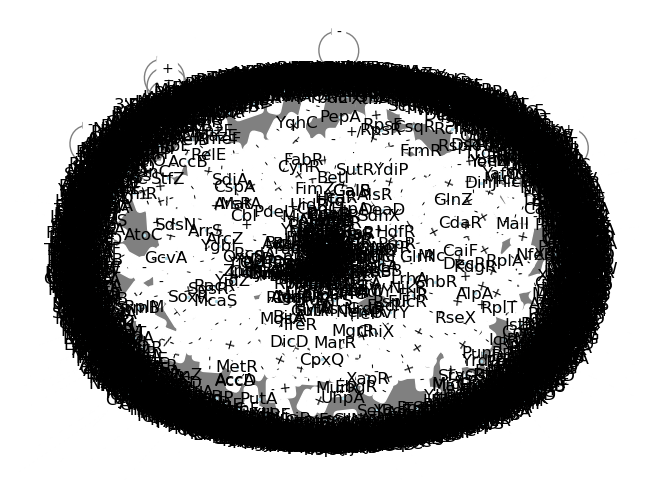

In [11]:
# Load ecoli GRN text file and display it
file_path = './ECOLI-regulatory-network.txt'  
ecoli_network = parse_regulation_file(file_path)
draw_network(ecoli_network)

In [12]:
# remove cycles
#acyclic_ecoli_network = convert_to_acyclic_graph_dfs(ecoli_network)
#assert(nx.is_directed_acyclic_graph(acyclic_ecoli_network))
#draw_network(acyclic_ecoli_network)

## LacI

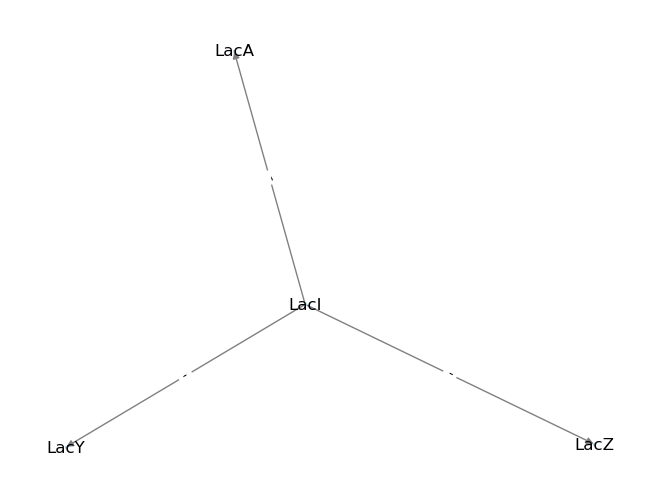

({'LacI': b_LacI,
  'LacY': K_LacI_LacY*(1 - x_LacI**n_LacI_LacY)/(h_LacI_LacY**n_LacI_LacY + x_LacI**n_LacI_LacY) + b_LacY,
  'LacZ': K_LacI_LacZ*(1 - x_LacI**n_LacI_LacZ)/(h_LacI_LacZ**n_LacI_LacZ + x_LacI**n_LacI_LacZ) + b_LacZ,
  'LacA': K_LacI_LacA*(1 - x_LacI**n_LacI_LacA)/(h_LacI_LacA**n_LacI_LacA + x_LacI**n_LacI_LacA) + b_LacA},
 {'LacI': b_LacI, 'LacY': b_LacY, 'LacZ': b_LacZ, 'LacA': b_LacA},
 {('LacI', 'LacA'): K_LacI_LacA,
  ('LacI', 'LacY'): K_LacI_LacY,
  ('LacI', 'LacZ'): K_LacI_LacZ},
 {('LacI', 'LacA'): n_LacI_LacA,
  ('LacI', 'LacY'): n_LacI_LacY,
  ('LacI', 'LacZ'): n_LacI_LacZ},
 {('LacI', 'LacA'): h_LacI_LacA,
  ('LacI', 'LacY'): h_LacI_LacY,
  ('LacI', 'LacZ'): h_LacI_LacZ},
 {'LacI': x_LacI, 'LacY': x_LacY, 'LacZ': x_LacZ, 'LacA': x_LacA})

{b_LacI: 0.9343329959349258,
 b_LacY: 0,
 b_LacZ: 0,
 b_LacA: 0,
 K_LacI_LacA: 2.078969863495068,
 K_LacI_LacY: 3.8095948843223946,
 K_LacI_LacZ: 3.635607226299429,
 n_LacI_LacA: 2,
 n_LacI_LacY: 2,
 n_LacI_LacZ: 2,
 h_LacI_LacA: 4.956501276434933,
 h_LacI_LacY: 2.060189149637133,
 h_LacI_LacZ: 3.6882380106469417}

{'LacI': 0, 'LacY': 1, 'LacZ': 2, 'LacA': 3}

,Target Idx,#regulators,regIdx1,K1,coop_state1
0,1,1,0,-3.809595,2
1,2,1,0,-3.635607,2
2,3,1,0,-2.078970,2


,Master regulator Idx,production_rate
0,0,0.934333


In [13]:
# get subgraph for "LacI"
# LacI_network = generate_subnetwork_with_backdoor_adjustment(acyclic_ecoli_network,"LacI")  # very slow
LacI_network_all = get_subgraph_from_nodes(ecoli_network, ["LacI"], descendants_only=True)
LacI_network_dag = convert_to_acyclic_graph(LacI_network_all)
#assert(nx.is_directed_acyclic_graph(LacI_all_ancestors_network))

# plot subgraph
draw_network(LacI_network_dag)

# get hill equations
LacI_hill_equations = generate_hill_equations(LacI_network_dag)
display(LacI_hill_equations)

# set parameter values
# define symbols for the LacI network
basal_rates_laci = {gene: sy.Symbol(f'b_{gene}') for gene in LacI_network_dag.nodes()}
max_contributions_laci = {(regulator, gene): sy.Symbol(f'K_{regulator}_{gene}') for regulator, gene in LacI_network_dag.edges()}
hill_coefficients_laci = {(regulator, gene): sy.Symbol(f'n_{regulator}_{gene}') for regulator, gene in LacI_network_dag.edges()}
half_responses_laci = {(regulator, gene): sy.Symbol(f'h_{regulator}_{gene}') for regulator, gene in LacI_network_dag.edges()}

# define distribution settings for the parameters
master_regulators = [node for node, indegree in LacI_network_dag.in_degree() if indegree == 0]
param_distributions_laci = {
    'K': {'min': 1, 'max': 5},
    'n': 2,
    'h': {'min': 1, 'max': 5},
    'b': {'a': 2, 'b': 5, 'scale': 4},
    'master_regulators': master_regulators  # LacI is a master regulator
    }

parameter_values_laci = assign_parameter_values(basal_rates_laci, 
                                                max_contributions_laci, 
                                                hill_coefficients_laci, 
                                                half_responses_laci, 
                                                param_distributions_laci)

display(parameter_values_laci)

# get dataframes for sergio
node_to_idx_laci = {gene: idx for idx, gene in enumerate(LacI_network_dag.nodes())}
display(node_to_idx_laci)
targets_df, regulators_df = create_input_files_for_build_graph(LacI_network_dag,
                                                               parameter_values_laci,
                                                               node_to_idx_laci, 
                                                               basal_rates_laci, 
                                                               max_contributions_laci, 
                                                               hill_coefficients_laci)
display(targets_df)
display(regulators_df)

# save results to file
save_dataframes_to_csv(targets_df, regulators_df, "LacI_targets.csv", "LacI_regs.csv")
nx.write_gexf(LacI_network_dag, "LacI_network.gexf")


### TyrR

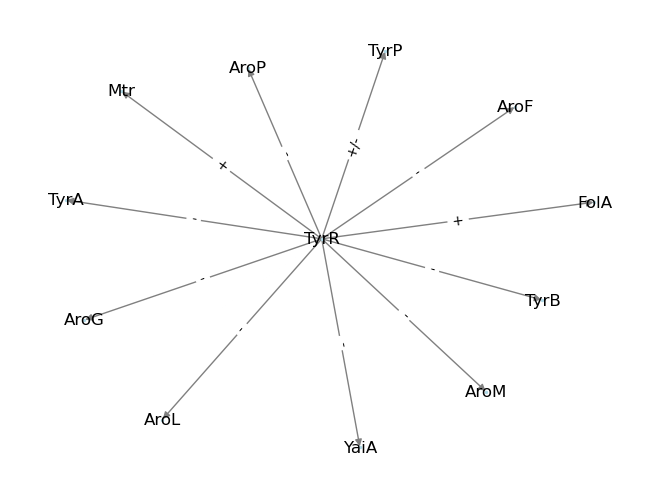

({'TyrR': b_TyrR,
  'Mtr': K_TyrR_Mtr*x_TyrR**n_TyrR_Mtr/(h_TyrR_Mtr**n_TyrR_Mtr + x_TyrR**n_TyrR_Mtr) + b_Mtr,
  'FolA': K_TyrR_FolA*x_TyrR**n_TyrR_FolA/(h_TyrR_FolA**n_TyrR_FolA + x_TyrR**n_TyrR_FolA) + b_FolA,
  'AroM': K_TyrR_AroM*(1 - x_TyrR**n_TyrR_AroM)/(h_TyrR_AroM**n_TyrR_AroM + x_TyrR**n_TyrR_AroM) + b_AroM,
  'AroG': K_TyrR_AroG*(1 - x_TyrR**n_TyrR_AroG)/(h_TyrR_AroG**n_TyrR_AroG + x_TyrR**n_TyrR_AroG) + b_AroG,
  'AroP': K_TyrR_AroP*(1 - x_TyrR**n_TyrR_AroP)/(h_TyrR_AroP**n_TyrR_AroP + x_TyrR**n_TyrR_AroP) + b_AroP,
  'YaiA': K_TyrR_YaiA*(1 - x_TyrR**n_TyrR_YaiA)/(h_TyrR_YaiA**n_TyrR_YaiA + x_TyrR**n_TyrR_YaiA) + b_YaiA,
  'AroL': K_TyrR_AroL*(1 - x_TyrR**n_TyrR_AroL)/(h_TyrR_AroL**n_TyrR_AroL + x_TyrR**n_TyrR_AroL) + b_AroL,
  'TyrP': K_TyrR_TyrP*(1 - x_TyrR**n_TyrR_TyrP)/(h_TyrR_TyrP**n_TyrR_TyrP + x_TyrR**n_TyrR_TyrP) + b_TyrP,
  'AroF': K_TyrR_AroF*(1 - x_TyrR**n_TyrR_AroF)/(h_TyrR_AroF**n_TyrR_AroF + x_TyrR**n_TyrR_AroF) + b_AroF,
  'TyrB': K_TyrR_TyrB*(1 - x_TyrR**n_T

{b_TyrR: 1.6690045798841688,
 b_Mtr: 0,
 b_FolA: 0,
 b_AroM: 0,
 b_AroG: 0,
 b_AroP: 0,
 b_YaiA: 0,
 b_AroL: 0,
 b_TyrP: 0,
 b_AroF: 0,
 b_TyrB: 0,
 b_TyrA: 0,
 K_TyrR_AroF: 4.784747575965045,
 K_TyrR_AroG: 3.3190857670499185,
 K_TyrR_AroL: 3.1608690671144744,
 K_TyrR_AroM: 1.2012917317386558,
 K_TyrR_AroP: 1.2516299040720957,
 K_TyrR_FolA: 1.7493871653071555,
 K_TyrR_Mtr: 1.1298830867669931,
 K_TyrR_TyrA: 3.9734115822800495,
 K_TyrR_TyrB: 3.8933212159758526,
 K_TyrR_TyrP: 1.5442249377265718,
 K_TyrR_YaiA: 4.344315603181124,
 n_TyrR_AroF: 2,
 n_TyrR_AroG: 2,
 n_TyrR_AroL: 2,
 n_TyrR_AroM: 2,
 n_TyrR_AroP: 2,
 n_TyrR_FolA: 2,
 n_TyrR_Mtr: 2,
 n_TyrR_TyrA: 2,
 n_TyrR_TyrB: 2,
 n_TyrR_TyrP: 2,
 n_TyrR_YaiA: 2,
 h_TyrR_AroF: 1.619144139384448,
 h_TyrR_AroG: 2.204702347989435,
 h_TyrR_AroL: 1.99590759664546,
 h_TyrR_AroM: 2.489228394292191,
 h_TyrR_AroP: 2.0186550635598475,
 h_TyrR_FolA: 2.9558037057538082,
 h_TyrR_Mtr: 2.6296315254187417,
 h_TyrR_TyrA: 4.946277963117306,
 h_TyrR_TyrB: 1.22

{'TyrR': 0,
 'Mtr': 1,
 'FolA': 2,
 'AroM': 3,
 'AroG': 4,
 'AroP': 5,
 'YaiA': 6,
 'AroL': 7,
 'TyrP': 8,
 'AroF': 9,
 'TyrB': 10,
 'TyrA': 11}

,Target Idx,#regulators,regIdx1,K1,coop_state1
0,1,1,0,1.129883,2
1,2,1,0,1.749387,2
2,3,1,0,-1.201292,2
3,4,1,0,-3.319086,2
4,5,1,0,-1.251630,2
5,6,1,0,-4.344316,2
6,7,1,0,-3.160869,2
7,8,1,0,1.544225,2
8,9,1,0,-4.784748,2
9,10,1,0,-3.893321,2


,Master regulator Idx,production_rate
0,0,1.669005


In [14]:
# get subgraph for "TyrR"
# TyrR_network = generate_subnetwork_with_backdoor_adjustment(acyclic_ecoli_network,"TyrR")  # very slow
TyrR_network_all = get_subgraph_from_nodes(ecoli_network, ["TyrR"], descendants_only=True)
TyrR_network_dag = convert_to_acyclic_graph(TyrR_network_all)
#assert(nx.is_directed_acyclic_graph(TyrR_all_ancestors_network))

# plot subgraph
draw_network(TyrR_network_dag)

# get hill equations
TyrR_hill_equations = generate_hill_equations(TyrR_network_dag)
display(TyrR_hill_equations)

# set parameter values
# define symbols for the TyrR network
basal_rates_TyrR = {gene: sy.Symbol(f'b_{gene}') for gene in TyrR_network_dag.nodes()}
max_contributions_TyrR = {(regulator, gene): sy.Symbol(f'K_{regulator}_{gene}') for regulator, gene in TyrR_network_dag.edges()}
hill_coefficients_TyrR = {(regulator, gene): sy.Symbol(f'n_{regulator}_{gene}') for regulator, gene in TyrR_network_dag.edges()}
half_responses_TyrR = {(regulator, gene): sy.Symbol(f'h_{regulator}_{gene}') for regulator, gene in TyrR_network_dag.edges()}

# define distribution settings for the parameters
master_regulators = [node for node, indegree in TyrR_network_dag.in_degree() if indegree == 0]
param_distributions_TyrR = {
    'K': {'min': 1, 'max': 5},
    'n': 2,
    'h': {'min': 1, 'max': 5},
    'b': {'a': 2, 'b': 5, 'scale': 4},
    'master_regulators': master_regulators  # TyrR is a master regulator
    }

parameter_values_TyrR = assign_parameter_values(basal_rates_TyrR, 
                                                max_contributions_TyrR, 
                                                hill_coefficients_TyrR, 
                                                half_responses_TyrR, 
                                                param_distributions_TyrR)

display(parameter_values_TyrR)

# get dataframes for sergio
node_to_idx_TyrR = {gene: idx for idx, gene in enumerate(TyrR_network_dag.nodes())}
display(node_to_idx_TyrR)
targets_df, regulators_df = create_input_files_for_build_graph(TyrR_network_dag,
                                                               parameter_values_TyrR,
                                                               node_to_idx_TyrR, 
                                                               basal_rates_TyrR, 
                                                               max_contributions_TyrR, 
                                                               hill_coefficients_TyrR)
display(targets_df)
display(regulators_df)

# save results to file
save_dataframes_to_csv(targets_df, regulators_df, "TyrR_targets.csv", "TyrR_regs.csv")
nx.write_gexf(TyrR_network_dag, "TyrR_network.gexf")

### FadR

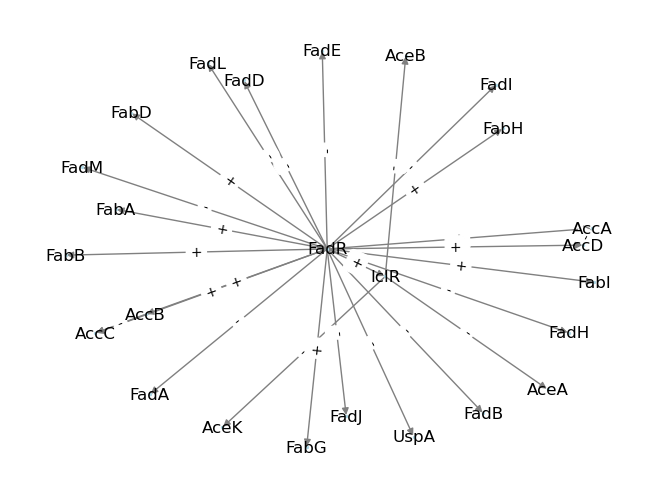

({'FabG': K_FadR_FabG*x_FadR**n_FadR_FabG/(h_FadR_FabG**n_FadR_FabG + x_FadR**n_FadR_FabG) + b_FabG,
  'AccD': K_AccA_AccD*(1 - x_AccA**n_AccA_AccD)/(h_AccA_AccD**n_AccA_AccD + x_AccA**n_AccA_AccD) + K_FadR_AccD*x_FadR**n_FadR_AccD/(h_FadR_AccD**n_FadR_AccD + x_FadR**n_FadR_AccD) + b_AccD,
  'FabH': K_FadR_FabH*x_FadR**n_FadR_FabH/(h_FadR_FabH**n_FadR_FabH + x_FadR**n_FadR_FabH) + b_FabH,
  'FadA': K_FadR_FadA*(1 - x_FadR**n_FadR_FadA)/(h_FadR_FadA**n_FadR_FadA + x_FadR**n_FadR_FadA) + b_FadA,
  'FadD': K_FadR_FadD*(1 - x_FadR**n_FadR_FadD)/(h_FadR_FadD**n_FadR_FadD + x_FadR**n_FadR_FadD) + b_FadD,
  'IclR': K_FadR_IclR*x_FadR**n_FadR_IclR/(h_FadR_IclR**n_FadR_IclR + x_FadR**n_FadR_IclR) + b_IclR,
  'AceA': K_IclR_AceA*(1 - x_IclR**n_IclR_AceA)/(h_IclR_AceA**n_IclR_AceA + x_IclR**n_IclR_AceA) + b_AceA,
  'FadI': K_FadR_FadI*(1 - x_FadR**n_FadR_FadI)/(h_FadR_FadI**n_FadR_FadI + x_FadR**n_FadR_FadI) + b_FadI,
  'AceK': K_IclR_AceK*(1 - x_IclR**n_IclR_AceK)/(h_IclR_AceK**n_IclR_AceK + x_I

{b_FabG: 0,
 b_AccD: 0,
 b_FabH: 0,
 b_FadA: 0,
 b_FadD: 0,
 b_IclR: 0,
 b_AceA: 0,
 b_FadI: 0,
 b_AceK: 0,
 b_FabD: 0,
 b_AceB: 0,
 b_AccA: 0,
 b_AccC: 0,
 b_FadH: 0,
 b_FadM: 0,
 b_AccB: 0,
 b_UspA: 0,
 b_FabI: 0,
 b_FabA: 0,
 b_FabB: 0,
 b_FadR: 0.4396771031175713,
 b_FadE: 0,
 b_FadB: 0,
 b_FadJ: 0,
 b_FadL: 0,
 K_IclR_AceA: 3.5128263883721758,
 K_IclR_AceB: 1.4854876981944787,
 K_IclR_AceK: 4.943736674499672,
 K_AccA_AccD: 4.122728298751449,
 K_AccB_AccC: 2.5609541983359803,
 K_FadR_AccA: 3.3142557291174177,
 K_FadR_AccB: 4.6453672648656354,
 K_FadR_AccC: 3.2163971215833045,
 K_FadR_AccD: 1.6979939455918207,
 K_FadR_FabA: 2.5148134223246372,
 K_FadR_FabB: 4.372579460118981,
 K_FadR_FabD: 3.5768520639584716,
 K_FadR_FabG: 3.6028975373352012,
 K_FadR_FabH: 4.467285942753957,
 K_FadR_FabI: 4.575892229850019,
 K_FadR_FadA: 4.679170287117746,
 K_FadR_FadB: 1.3793967730126244,
 K_FadR_FadD: 3.1765040078524036,
 K_FadR_FadE: 3.9620380848732744,
 K_FadR_FadH: 4.027707380508055,
 K_FadR_Fa

{'FabG': 0,
 'AccD': 1,
 'FabH': 2,
 'FadA': 3,
 'FadD': 4,
 'IclR': 5,
 'AceA': 6,
 'FadI': 7,
 'AceK': 8,
 'FabD': 9,
 'AceB': 10,
 'AccA': 11,
 'AccC': 12,
 'FadH': 13,
 'FadM': 14,
 'AccB': 15,
 'UspA': 16,
 'FabI': 17,
 'FabA': 18,
 'FabB': 19,
 'FadR': 20,
 'FadE': 21,
 'FadB': 22,
 'FadJ': 23,
 'FadL': 24}

,Target Idx,#regulators,regIdx1,regIdx2,K1,K2,coop_state1,coop_state2
0,0,1,20,NaN,3.602898,NaN,2,NaN
1,1,2,11,20.0,-4.122728,1.697994,2,2.0
2,2,1,20,NaN,4.467286,NaN,2,NaN
3,3,1,20,NaN,-4.679170,NaN,2,NaN
4,4,1,20,NaN,-3.176504,NaN,2,NaN
5,5,1,20,NaN,1.344543,NaN,2,NaN
6,6,1,5,NaN,-3.512826,NaN,2,NaN
7,7,1,20,NaN,-3.426865,NaN,2,NaN
8,8,1,5,NaN,-4.943737,NaN,2,NaN
9,9,1,20,NaN,3.576852,NaN,2,NaN


,Master regulator Idx,production_rate
0,20,0.439677


In [15]:
# get subgraph for "FadR"
# FadR_network = generate_subnetwork_with_backdoor_adjustment(acyclic_ecoli_network,"FadR")  # very slow
FadR_network_all = get_subgraph_from_nodes(ecoli_network, ["FadR"], descendants_only=True)
FadR_network_dag = convert_to_acyclic_graph(FadR_network_all)
#assert(nx.is_directed_acyclic_graph(FadR_all_ancestors_network))

# plot subgraph
draw_network(FadR_network_dag)

# get hill equations
FadR_hill_equations = generate_hill_equations(FadR_network_dag)
display(FadR_hill_equations)

# set parameter values
# define symbols for the FadR network
basal_rates_FadR = {gene: sy.Symbol(f'b_{gene}') for gene in FadR_network_dag.nodes()}
max_contributions_FadR = {(regulator, gene): sy.Symbol(f'K_{regulator}_{gene}') for regulator, gene in FadR_network_dag.edges()}
hill_coefficients_FadR = {(regulator, gene): sy.Symbol(f'n_{regulator}_{gene}') for regulator, gene in FadR_network_dag.edges()}
half_responses_FadR = {(regulator, gene): sy.Symbol(f'h_{regulator}_{gene}') for regulator, gene in FadR_network_dag.edges()}

# define distribution settings for the parameters
master_regulators = [node for node, indegree in FadR_network_dag.in_degree() if indegree == 0]
param_distributions_FadR = {
    'K': {'min': 1, 'max': 5},
    'n': 2,
    'h': {'min': 1, 'max': 5},
    'b': {'a': 2, 'b': 5, 'scale': 4},
    'master_regulators': master_regulators  # FadR is a master regulator
    }

parameter_values_FadR = assign_parameter_values(basal_rates_FadR, 
                                                max_contributions_FadR, 
                                                hill_coefficients_FadR, 
                                                half_responses_FadR, 
                                                param_distributions_FadR)

display(parameter_values_FadR)

# get dataframes for sergio
node_to_idx_FadR = {gene: idx for idx, gene in enumerate(FadR_network_dag.nodes())}
display(node_to_idx_FadR)
targets_df, regulators_df = create_input_files_for_build_graph(FadR_network_dag,
                                                               parameter_values_FadR,
                                                               node_to_idx_FadR, 
                                                               basal_rates_FadR, 
                                                               max_contributions_FadR, 
                                                               hill_coefficients_FadR)
display(targets_df)
display(regulators_df)

# save results to file
save_dataframes_to_csv(targets_df, regulators_df, "FadR_targets.txt", "FadR_regs.txt")
nx.write_gexf(FadR_network_dag, "FadR_network.gexf")

# Cytoscape visualization demo

In [16]:
import ipycytoscape

def draw_cytoscape_network(G):
    # Create a Cytoscape graph
    cyto_graph = ipycytoscape.CytoscapeWidget()

    # Calculate the positions of the nodes using the spring layout algorithm
    pos = nx.spring_layout(G)

    # Add nodes with labels and positions
    for node in G.nodes():
        cyto_node = ipycytoscape.Node(data={"id": node, "label": str(node)}, 
                                      position={'x': pos[node][0], 'y': pos[node][1]})
        cyto_graph.graph.add_node(cyto_node)

    # Add edges with polarity attribute
    for edge in G.edges(data=True):
        source, target, data = edge
        cyto_edge = ipycytoscape.Edge(data={"source": source, "target": target, "polarity": data['polarity']})
        cyto_graph.graph.add_edge(cyto_edge)

    # Define a style for the edges
    edge_style = [
        {
            'selector': 'edge[polarity = "+"]',
            'style': {
                'line-color': 'green',
                'curve-style': 'bezier',
                'target-arrow-shape': 'triangle',
                'target-arrow-color': 'green'
            }
        },
        {
            'selector': 'edge[polarity = "-"]',
            'style': {
                'line-color': 'red',
                'curve-style': 'bezier',
                'target-arrow-shape': 'triangle',
                'target-arrow-color': 'red'
            }
        },
        {
            'selector': 'edge[polarity = "+/-"]',
            'style': {
                'line-color': 'black',
                'curve-style': 'bezier',
                'target-arrow-shape': 'triangle',
                'target-arrow-color': 'black'
            }
        }
    ]

    # Define a style for the nodes to display the labels
    node_style = [
        {
            'selector': 'node',
            'style': {
                'label': 'data(label)'
            }
        }
    ]

    # Apply the styles to the graph
    cyto_graph.set_style(edge_style + node_style)

    # Display the graph
    return cyto_graph

subgraph = process_graph(ecoli_network, ['TyrR'], descendants_only=True, full_network_name="ecoli", print_results=False, save_results=False, plot_subgraph=False)

cyto_graph = draw_cytoscape_network(subgraph)

cyto_graph

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'edge[polarity = "+"]', 'styl…